# My Spotify wrapped
https://developer.spotify.com/documentation/web-api


In [1]:
import asyncio
import requests
import json
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

### Get Data from your Spotify account

We will write an asynchronous function which interacts with Spotify Web API to make HTTP requests.
- Asynchronous function allows you to perform concurrent or parallel operations without waiting for each operation to complete before starting the next one. 

Get access token from https://developer.spotify.com/
##### fetch_web_api 
Takes parameters 
- endpoint -> Request URL
- method -> http method  'GET', 'POST', 'PUT', etc
- request body -> if any

- The function makes an HTTP request using requests.request() from the requests library. It includes the specified HTTP method, URL, headers, and optional request body.
- The response from the API is stored in the response variable.
- The function returns the JSON content of the API response using response.json(), converting the response content into a Python dictionary.

##### get_top_tracks
Retrieves the user's top 50 tracks from the Spotify API
- Upon receiving the API response, the function attempts to extract the track information from the 'items' key in the response JSON.
- It iterates through each track in the 'items' list, extracting specific details for each track, such as the track name, album name, artists involved, popularity, duration, track ID, and URI.
- Each track's information is stored as a dictionary (track_info) and appended to the tracks_info list.
- Returns the tracks_info list containing dictionaries, each representing the details of a top track. If the 'items' key is not found, an empty list is returned.

The result from this funtion is converted to a pandas dataframe for further analsys

In [ ]:
token = 'BQASXtt5___________MRMVJz'

async def fetch_web_api(endpoint, method, body=None):
    headers = {
        'Authorization': f'Bearer {token}'
    }
    url = f'https://api.spotify.com/{endpoint}'

    if body:
        body = json.dumps(body)

    response = requests.request(method, url, headers=headers, data=body)
    return response.json()

async def get_top_tracks():
    """
    Get Top 50 Tracks
    """
    response = await fetch_web_api(
        'v1/me/top/tracks?time_range=long_term&limit=50&offset=0', 'GET'
    ) # Endpoint reference: https://developer.spotify.com/documentation/web-api/reference/get-users-top-artists-and-tracks
    try:
        top_tracks = response['items']
        tracks_info = []
        for track in top_tracks:
            track_info = {
                'name': track['name'],
                'album': track['album']['name'],
                'artists': ', '.join(artist['name'] for artist in track['artists']),
                'popularity': track['popularity'],
                'duration': track['duration_ms'],
                'release_date': track['album']['release_date'],
                'id': track['id'],
                'uri': track['uri']
            }
            tracks_info.append(track_info)
        return tracks_info
    except KeyError:
        print("Error: 'items' key not found in response:", response)
        return []


top_tracks = await get_top_tracks()
top_tracks_df = pd.DataFrame(top_tracks)
top_tracks_df.head()

In [ ]:
async def get_track_features(track_ids):
    response = await fetch_web_api(
            f'v1/audio-features?ids={track_ids}', 'GET'
        ) # Endpoint reference: https://developer.spotify.com/documentation/web-api/reference/get-several-audio-features

    try:
        track_features = response['audio_features']
        tracks = []
        for track in track_features:
            track_info = {
                'danceability': track['danceability'],
                'energy': track['energy'],
                'key': track['key'],
                'loudness': track['loudness'],
                'mode': track['mode'],
                'speechiness': track['speechiness'],
                'acousticness': track['acousticness'],
                'instrumentalness': track['instrumentalness'],
                'liveness': track['liveness'],
                'valence': track['valence'],
                'tempo': track['tempo'],
                'liveness': track['liveness'],
                'duration_ms': track['duration_ms'],
                'time_signature': track['time_signature'],
                'id': track['id'],
                'uri': track['uri']
            }
            tracks.append(track_info)
        return tracks
    except KeyError:
        print("Error: 'items' key not found in response:", response)
        return []
    
track_ids = top_tracks_df['id'].unique().tolist()
track_ids = ','.join(track_ids)

track_features = await get_track_features(track_ids)
track_features_df = pd.DataFrame(track_features)
track_features_df.head()

In [ ]:
tracks_df = pd.merge(top_tracks_df, track_features_df, on='id', how='left')
tracks_df

##### get_top_artists
Retrieves the user's top 25 artists from the Spotify API
- Upon receiving the API response, the function attempts to extract the artist information from the 'items' key in the response JSON.
- It iterates through each artist in the 'items' list, extracting specific details for each track, such as the artist's name, popularity, genre, followers, artist ID, and URI.
- Each artist's information is stored as a dictionary (artist_info) and appended to the artists_info list.
- Returns the artists_info list containing dictionaries, each representing the details of a top track. If the 'items' key is not found, an empty list is returned.

In [ ]:
async def get_top_artist():
    """
    Get Top 25 Artists
    """
    response = await fetch_web_api(
        'v1/me/top/artists?time_range=long_term&limit=25&offset=0', 'GET'
    ) # Endpoint reference: https://developer.spotify.com/documentation/web-api/reference/get-users-top-artists-and-tracks
    try:
        top_artists = response['items']
        artists_info = []
        for artist in top_artists:
            artist_info = {
                'name': artist['name'],
                'popularity': artist['popularity'],
                'type': artist['type'],
                'genres': ', '.join(genre for genre in artist['genres']),
                'followers': artist['followers']['total'],
                'id': artist['id'],
                'uri': artist['uri']
            }
            artists_info.append(artist_info)
        return artists_info
    except KeyError:
        print("Error: 'items' key not found in response:", response)
        return []


top_artist = await get_top_artist()
top_artist_df = pd.DataFrame(top_artist)
top_artist_df.head()

In [ ]:
# save both dataframes to CSV
tracks_df.to_csv('top_tracks.csv', index=False)
top_artist_df.to_csv('top_artists.csv', index=False)

### Import data / User the df created above

In [2]:
top_tracks_df = pd.read_csv('top_tracks.csv')
top_artist_df = pd.read_csv('top_artists.csv')

In [3]:
top_tracks_df.head()

,name,album,artists,popularity,duration,release_date,id,uri_x,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,uri_y
0,All Too Well (10 Minute Version) (Taylor's Ver...,Red (Taylor's Version),Taylor Swift,86,613026,2021-11-12,5enxwA8aAbwZbf5qCHORXi,spotify:track:5enxwA8aAbwZbf5qCHORXi,0.631,0.518,...,1,0.0303,0.27400,0.000000,0.088,0.205,93.023,613027,4,spotify:track:5enxwA8aAbwZbf5qCHORXi
1,In Over My Head,Death Of An Optimist,grandson,49,198365,2020-12-04,3r0mb1tzAcCNoA8YRXuIhZ,spotify:track:3r0mb1tzAcCNoA8YRXuIhZ,0.582,0.817,...,1,0.0399,0.00170,0.015800,0.575,0.622,155.124,198366,4,spotify:track:3r0mb1tzAcCNoA8YRXuIhZ
2,What's Up,What's Up,"Gaullin, Lucky Luke",56,147540,2021-02-12,12yj178KaJo8PrddT0StaL,spotify:track:12yj178KaJo8PrddT0StaL,0.739,0.845,...,0,0.0397,0.00155,0.010700,0.775,0.839,121.997,147541,4,spotify:track:12yj178KaJo8PrddT0StaL
3,Sea Shanty / Wellerman,Sea Shanty / Wellerman,"Xd, Kaan Pars",25,136470,2021-01-29,0NuC9uTrLpsej0KAYV07BN,spotify:track:0NuC9uTrLpsej0KAYV07BN,0.788,0.794,...,1,0.0914,0.43800,0.000007,0.470,0.653,102.031,136471,4,spotify:track:0NuC9uTrLpsej0KAYV07BN
4,Beggin',Chosen,Måneskin,84,211560,2017-12-08,3Wrjm47oTz2sjIgck11l5e,spotify:track:3Wrjm47oTz2sjIgck11l5e,0.714,0.800,...,0,0.0504,0.12700,0.000000,0.359,0.589,134.002,211560,4,spotify:track:3Wrjm47oTz2sjIgck11l5e


In [4]:
top_artist_df.head()

,name,popularity,type,genres,followers,id,uri
0,Taylor Swift,100,artist,pop,0,06HL4z0CvFAxyc27GXpf02,spotify:artist:06HL4z0CvFAxyc27GXpf02
1,Machine Gun Kelly,75,artist,"ohio hip hop, pop rap",0,6TIYQ3jFPwQSRmorSezPxX,spotify:artist:6TIYQ3jFPwQSRmorSezPxX
2,Bazzi,69,artist,pop,0,4GvEc3ANtPPjt1ZJllr5Zl,spotify:artist:4GvEc3ANtPPjt1ZJllr5Zl
3,Lauv,74,artist,pop,0,5JZ7CnR6gTvEMKX4g70Amv,spotify:artist:5JZ7CnR6gTvEMKX4g70Amv
4,Tate McRae,86,artist,"alt z, pop",0,45dkTj5sMRSjrmBSBeiHym,spotify:artist:45dkTj5sMRSjrmBSBeiHym


In [5]:
unique_track_count = top_tracks_df.nunique()
unique_track_count

name                50
album               44
artists             43
popularity          32
duration            50
release_date        43
id                  50
uri_x               50
danceability        48
energy              49
key                 11
loudness            50
mode                 2
speechiness         48
acousticness        50
instrumentalness    26
liveness            47
valence             48
tempo               50
duration_ms         50
time_signature       1
uri_y               50
dtype: int64

In [6]:
unique_artist_count = top_artist_df.nunique()
unique_artist_count

name          25
popularity    20
type           1
genres        19
followers      1
id            25
uri           25
dtype: int64

I am using get_dummies to split the comma separated list of genres of each artist. This will help me aggregate based on genres for artists

In [7]:
genres = top_artist_df['genres'].str.get_dummies(', ')
top_artist_df = pd.concat([top_artist_df, genres], axis=1)
top_artist_df.head()

,name,popularity,type,genres,followers,id,uri,alt z,art pop,boy band,...,pop rap,post-teen pop,r&b,rap,singer-songwriter pop,southern hip hop,talent show,trap,uk pop,urban contemporary
0,Taylor Swift,100,artist,pop,0,06HL4z0CvFAxyc27GXpf02,spotify:artist:06HL4z0CvFAxyc27GXpf02,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Machine Gun Kelly,75,artist,"ohio hip hop, pop rap",0,6TIYQ3jFPwQSRmorSezPxX,spotify:artist:6TIYQ3jFPwQSRmorSezPxX,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,Bazzi,69,artist,pop,0,4GvEc3ANtPPjt1ZJllr5Zl,spotify:artist:4GvEc3ANtPPjt1ZJllr5Zl,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Lauv,74,artist,pop,0,5JZ7CnR6gTvEMKX4g70Amv,spotify:artist:5JZ7CnR6gTvEMKX4g70Amv,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Tate McRae,86,artist,"alt z, pop",0,45dkTj5sMRSjrmBSBeiHym,spotify:artist:45dkTj5sMRSjrmBSBeiHym,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
unique_artist_count = top_artist_df.nunique()
unique_artist_count

name                         25
popularity                   20
type                          1
genres                       19
followers                     1
id                           25
uri                          25
alt z                         2
art pop                       2
boy band                      2
canadian contemporary r&b     2
canadian pop                  2
dance pop                     2
dfw rap                       2
electropop                    2
etherpop                      2
filmi                         2
gen z singer-songwriter       2
indian instrumental           2
indie anthem-folk             2
indie pop rap                 2
indie poptimism               2
melodic rap                   2
modern bollywood              2
modern indie pop              2
ohio hip hop                  2
pop                           2
pop rap                       2
post-teen pop                 2
r&b                           2
rap                           2
singer-s

#### Now, lets ask some basic questions
- Q1. Which genre do I listen to the most
- Q2. From my top played, which is the most and least popular song
- Q3. See how many songs from each genre I like?
- Q4. Does the length of song play any role in the popularity of the song? Examined the impact of song duration on their success, providing nuanced insights into music trends.
- Q5. Do I prefer old/new songs?

In [10]:
print('top_artist_df: ', list(top_artist_df.columns))
print('\ntop_tracks_df: ', list(top_tracks_df.columns))

top_artist_df:  ['name', 'popularity', 'type', 'genres', 'followers', 'id', 'uri', 'alt z', 'art pop', 'boy band', 'canadian contemporary r&b', 'canadian pop', 'dance pop', 'dfw rap', 'electropop', 'etherpop', 'filmi', 'gen z singer-songwriter', 'indian instrumental', 'indie anthem-folk', 'indie pop rap', 'indie poptimism', 'melodic rap', 'modern bollywood', 'modern indie pop', 'ohio hip hop', 'pop', 'pop rap', 'post-teen pop', 'r&b', 'rap', 'singer-songwriter pop', 'southern hip hop', 'talent show', 'trap', 'uk pop', 'urban contemporary']

top_tracks_df:  ['name', 'album', 'artists', 'popularity', 'duration', 'release_date', 'id', 'uri_x', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'uri_y']


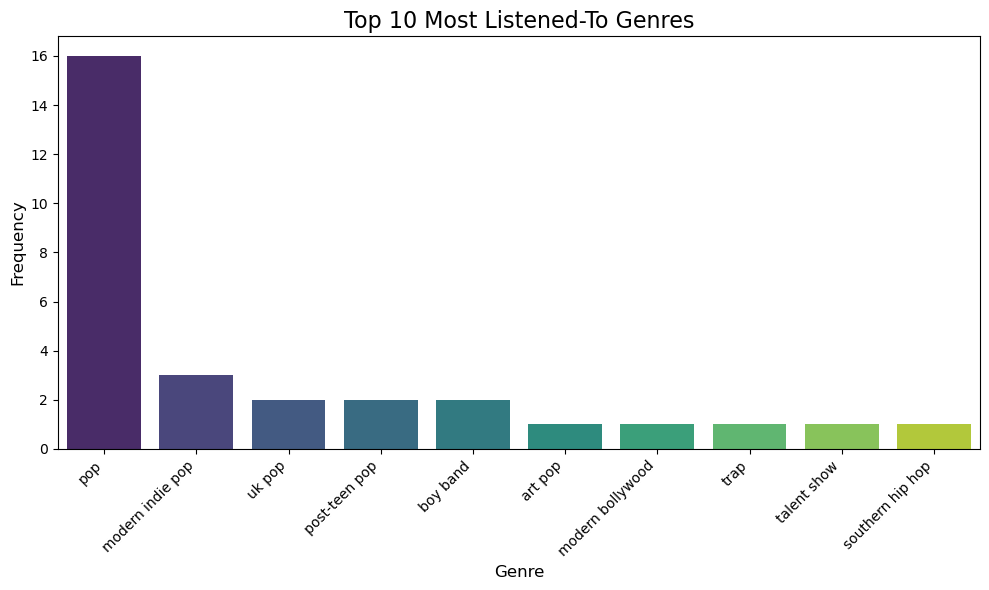

In [11]:
#Q1. Which genre do I listen to the most

genre_counts = top_artist_df.iloc[:, 8:].sum().sort_values(ascending=False)

top_genres = genre_counts.head(10)

# Plotting a bar graph for the most listened-to genres
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_genres.index, y=top_genres.values, palette="viridis")
ax.set_title('Top 10 Most Listened-To Genres', fontsize=16)
ax.set_xlabel('Genre', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_xticks(range(len(top_genres)))  # Set ticks based on the number of genres
ax.set_xticklabels(top_genres.index, rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

My Most Popular Songs:
+--------------+------------+
|     name     | popularity |
+--------------+------------+
| Cruel Summer |     98     |
+--------------+------------+
My Least Popular Songs:
+-----------------------------------------------------------------+------------+
|                              name                               | popularity |
+-----------------------------------------------------------------+------------+
| Don't Freak Out (feat. iann dior, Tyson Ritter & Travis Barker) |     0      |
|                       Bananza Temperature                       |     0      |
|                              Cold                               |     0      |
|                    The Most Beautiful Thing                     |     0      |
+-----------------------------------------------------------------+------------+


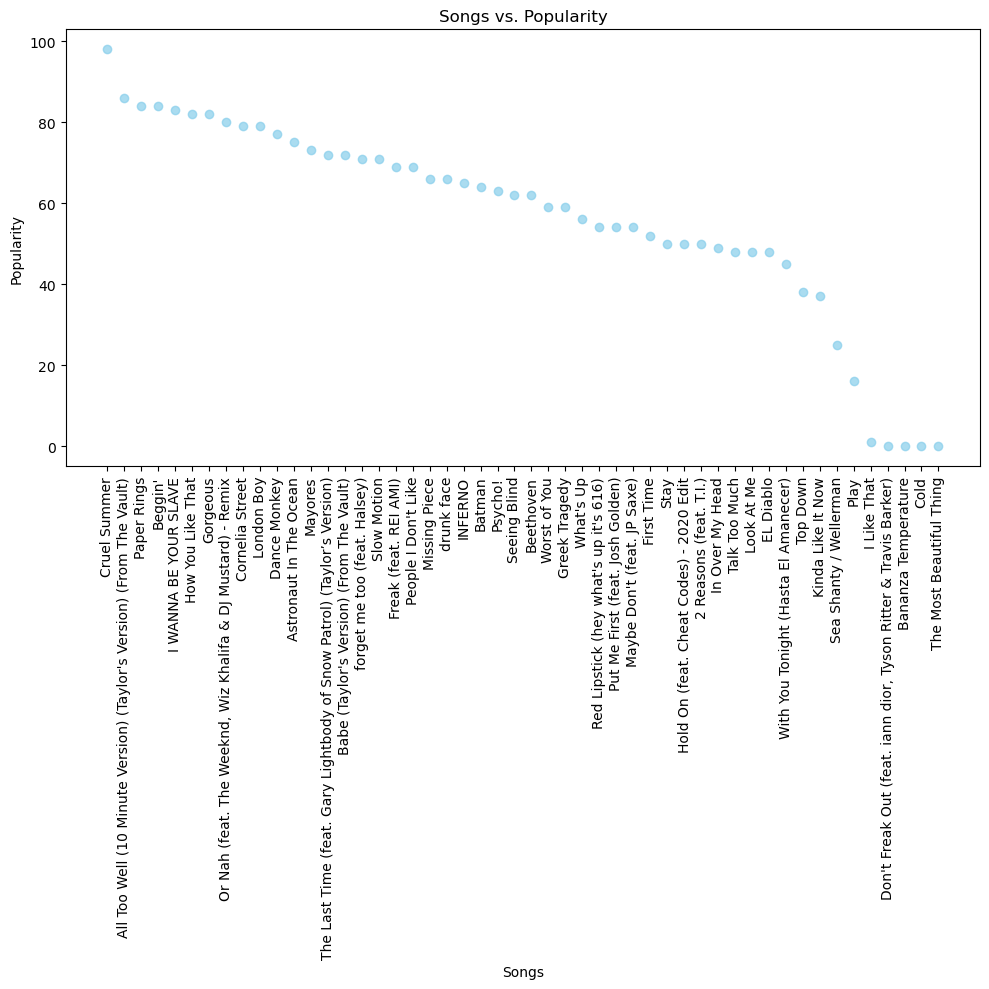

In [12]:
#Q2. From my top played, which is the most and least popular song

from tabulate import tabulate

most_popular_songs = top_tracks_df.loc[top_tracks_df['popularity'] == top_tracks_df['popularity'].max()]
least_popular_songs = top_tracks_df.loc[top_tracks_df['popularity'] == top_tracks_df['popularity'].min()]

# Create tables for most popular and least popular songs
most_popular_table = most_popular_songs[['name', 'popularity']]
least_popular_table = least_popular_songs[['name', 'popularity']]

# Print in a tabulated format
print("My Most Popular Songs:")
print(tabulate(most_popular_table, headers='keys', tablefmt='pretty', showindex=False))

print("My Least Popular Songs:")
print(tabulate(least_popular_table, headers='keys', tablefmt='pretty', showindex=False))

popularity_df = top_tracks_df.sort_values(by='popularity', ascending=False)
# Extracting data for the scatter plot
songs = popularity_df['name']
popularity = popularity_df['popularity']

# Plotting a scatter plot of songs vs. popularity
plt.figure(figsize=(10, 10))
plt.scatter(songs, popularity, color='skyblue', alpha=0.7)
plt.title('Songs vs. Popularity')
plt.xlabel('Songs')
plt.ylabel('Popularity')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability if needed
plt.tight_layout()
plt.show()

I observed many "pop" tracks (like 'art pop', 'canadian pop', 'dance pop', 'electropop',
       'etherpop', 'indie pop rap', 'indie poptimism', 'modern indie pop',
       'pop', 'pop rap', 'post-teen pop', 'singer-songwriter pop', 'uk pop') in my dataset, so I decided to merge them all as "pop"

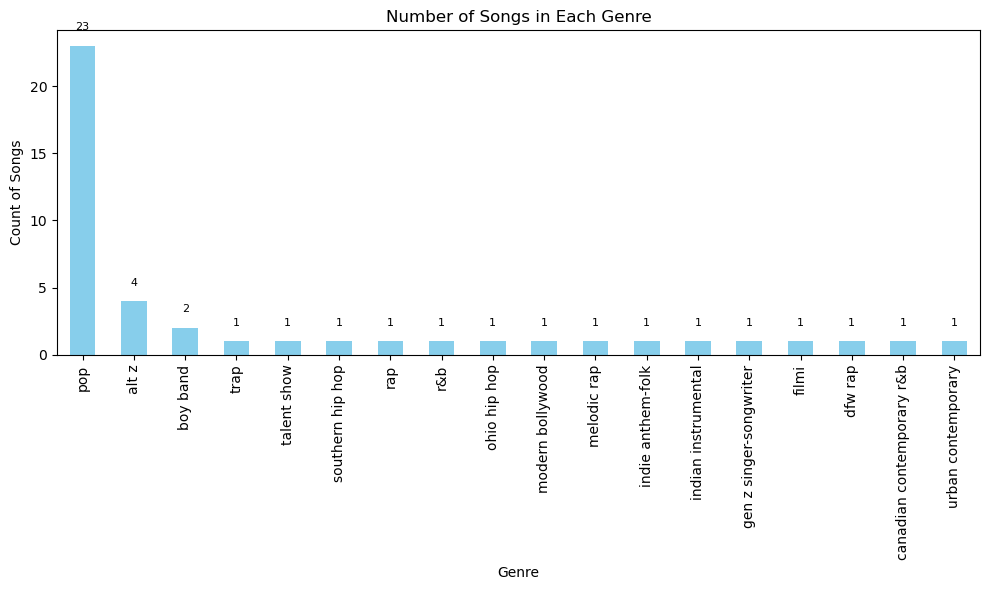

In [13]:
# Summing up the number of songs for each genre
genre_counts = top_artist_df.drop(['name', 'popularity', 'type', 'genres', 'followers', 'id', 'uri'], axis=1)
genre_counts['pop'] = (genre_counts.filter(like='pop') == 1).any(axis=1).astype(int)
pop_columns = genre_counts.filter(like='pop').columns
genre_counts = genre_counts.drop(columns=[col for col in pop_columns if col != 'pop'])
#genre_counts
genre_counts_sum = genre_counts.sum()

# Displaying the number of songs from each genre
genre_counts_sum = genre_counts_sum.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
bars = genre_counts_sum.plot(kind='bar', color='skyblue')
plt.title('Number of Songs in Each Genre')
plt.xlabel('Genre')
plt.ylabel('Count of Songs')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability if needed
for i, count in enumerate(genre_counts_sum):
    bars.text(i, count + 1, str(count), ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()



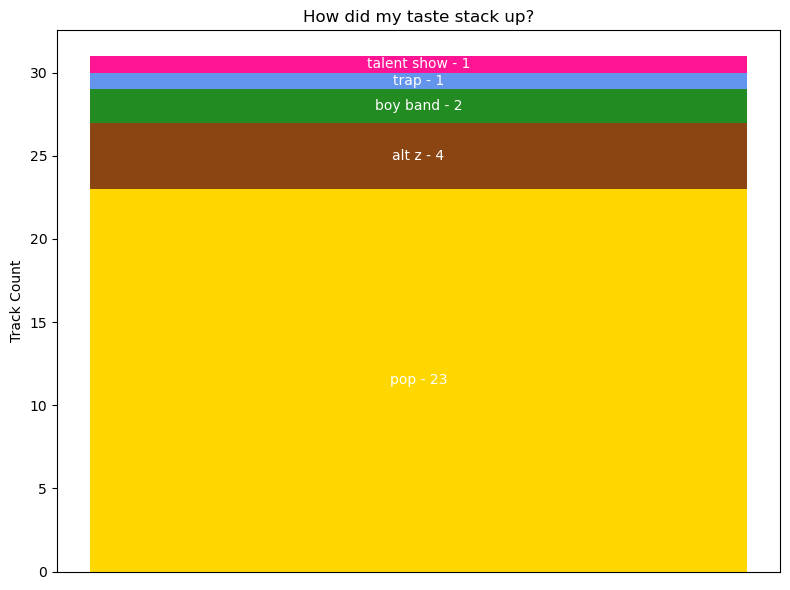

In [14]:
# How did my taste stack up? -> stack chart top 5 genres
layer_heights = genre_counts_sum.values[:5]
layer_labels = genre_counts_sum.index[:5]

# Colors for each genre
layer_colors = ['#FFD700', '#8B4513', '#228B22', '#6495ED', '#FF1493']  # Example colors for the genres

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plotting the aligned stacked bars for the top 5 genres
for i, (height, label, color) in enumerate(zip(layer_heights, layer_labels, layer_colors)):
    ax.bar(0, height, label=label, color=color, width=5, bottom=sum(layer_heights[:i]))
    # Annotate the value of each bar
    ax.annotate(f'{label} - {height}', xy=(0, sum(layer_heights[:i]) + height / 2), ha='center', va='center', color='white')

ax.set_ylabel('Track Count')
ax.set_title('How did my taste stack up?')
ax.set_xticks([])  # Hide x-axis ticks

# Show the plot
plt.tight_layout()
plt.show()

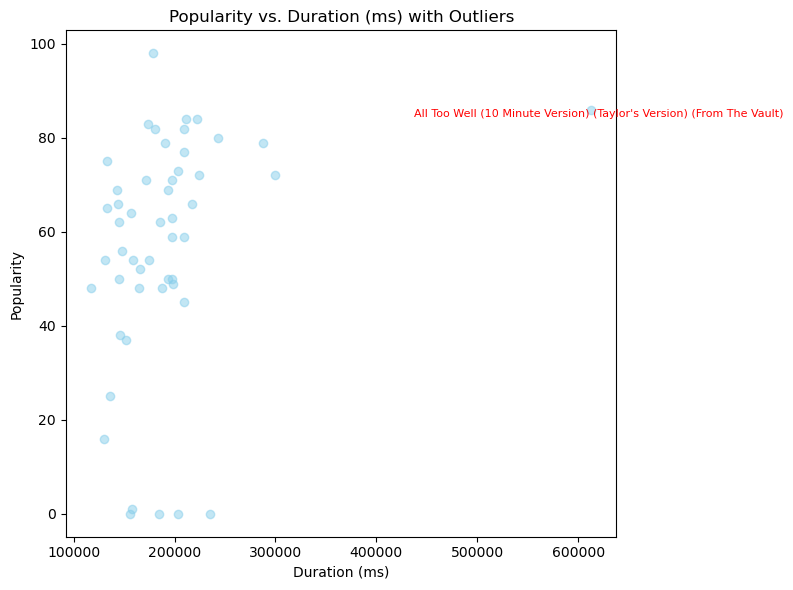

In [15]:
# Q4. Does the length of song play any role in the popularity of the song? Examined the impact of song duration on their success, providing nuanced insights into music trends.

import numpy as np
popularity = top_tracks_df['popularity']
duration_ms = top_tracks_df['duration_ms']
# Calculating z-scores for duration_ms
z_scores = np.abs((duration_ms - duration_ms.mean()) / duration_ms.std())

# Setting a threshold for z-scores to identify outliers (e.g., z-score greater than 3)
outlier_threshold = 2

# Plotting a scatter plot for popularity vs. duration_ms and labeling outliers
plt.figure(figsize=(8, 6))
plt.scatter(top_tracks_df['duration_ms'], top_tracks_df['popularity'], color='skyblue', alpha=0.5)

# Annotating outliers on the plot
for i, z in enumerate(z_scores):
    if z > outlier_threshold:
        plt.annotate(top_tracks_df['name'].iloc[i], (top_tracks_df['duration_ms'].iloc[i],  top_tracks_df['popularity'].iloc[i]), textcoords="offset points", xytext=(5,-5), ha='center', fontsize=8, color='red')

plt.title('Popularity vs. Duration (ms) with Outliers')
plt.xlabel('Duration (ms)')
plt.ylabel('Popularity')
plt.tight_layout()
plt.show()

Nope, it appears most of my most listened to songs are 2.5 minutes to 5 minutes long. The one exception, Taylor Swift's All Too Well (10 Minute Version) is a little over 10 minutes long, and is still in the top 80 percentile by popularity. 

C:\Users\Shagu\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


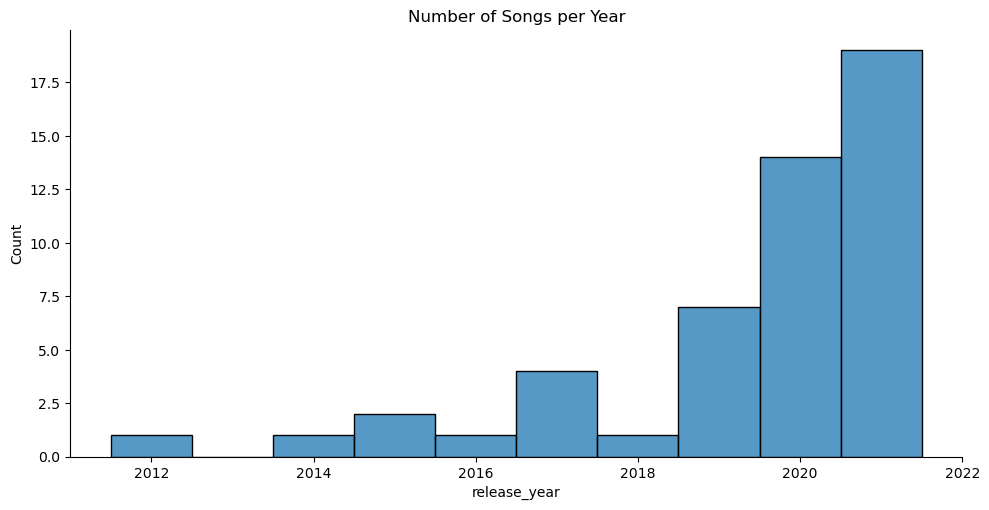

In [16]:
# What era of songs do I listen to?
import datetime
top_tracks_df['release_year'] = pd.to_datetime(top_tracks_df['release_date']).dt.year
sns.displot(top_tracks_df['release_year'], discrete=True, aspect=2, height=5, kind="hist").set(title="Number of Songs per Year")

In [17]:
top_tracks_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
popularity,50.0,56.540000,24.793194,0.000000,48.250000,62.000000,72.750000,98.000
duration,50.0,191275.380000,71804.188536,117160.000000,152839.500000,184915.500000,207614.250000,613026.000
danceability,50.0,0.725520,0.104540,0.502000,0.637500,0.740000,0.803750,0.942
energy,50.0,0.658380,0.165287,0.312000,0.557500,0.679500,0.792250,0.946
key,50.0,5.640000,3.584320,0.000000,2.000000,6.500000,9.000000,11.000
loudness,50.0,-6.188400,2.003760,-11.965000,-6.988000,-5.716500,-4.817250,-2.526
mode,50.0,0.660000,0.478518,0.000000,0.000000,1.000000,1.000000,1.000
speechiness,50.0,0.099870,0.090703,0.027800,0.039750,0.075300,0.120000,0.515
acousticness,50.0,0.185371,0.208942,0.000417,0.037525,0.096800,0.272500,0.781
instrumentalness,50.0,0.006972,0.027768,0.000000,0.000000,0.000002,0.000091,0.178


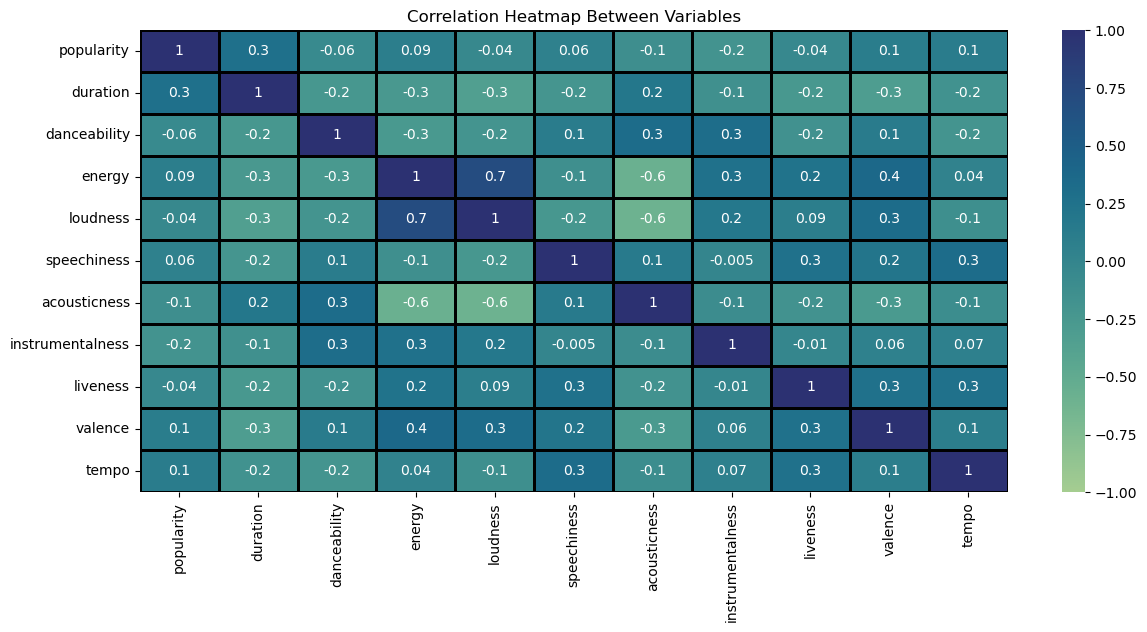

In [18]:
columns_for_corr = ['popularity', 'duration', 'danceability', 'energy', 'loudness', 'speechiness',
                    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

corr_df = top_tracks_df[columns_for_corr].corr(method="pearson")

# Plotting the correlation heatmap
plt.figure(figsize=(14, 6))
heatmap = sns.heatmap(corr_df, annot=True, fmt=".1g", vmin=-1, vmax=1, center=0, cmap="crest", linewidths=1, linecolor="black")
heatmap.set_title("Correlation Heatmap Between Variables")
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90)
plt.show()

I can see a strong correlation between Loudness and Energy, which intuitively makes sense

Text(0.5, 1.0, 'Are dancible songs more popular?')

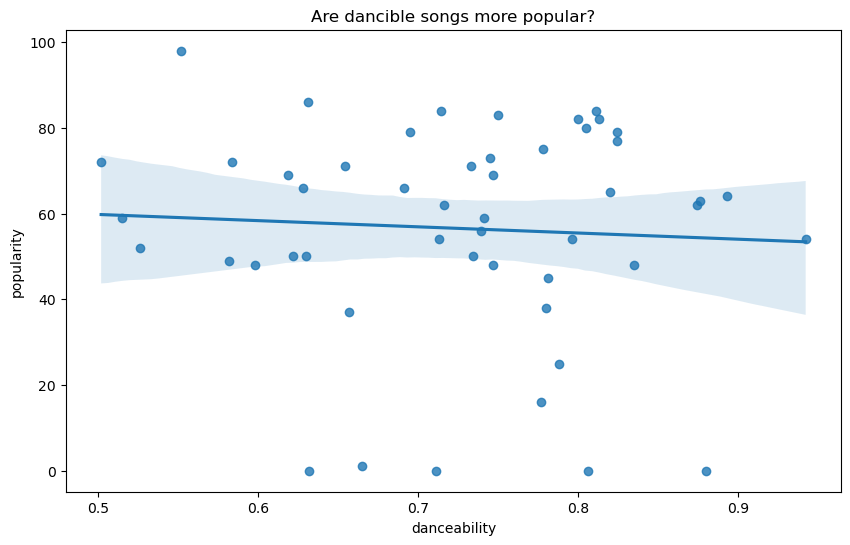

In [19]:
plt.figure(figsize=(10,6))
# regeration plot regplot
sns.regplot(data = top_tracks_df, y = "popularity", x = "danceability").set_title("Are dancible songs more popular?")

Text(0.5, 1.0, 'Are loud songs more dancible?')

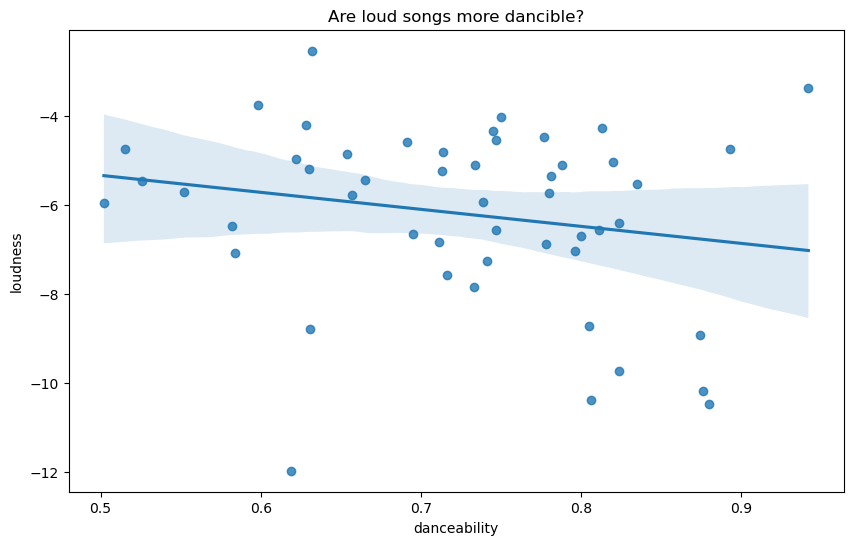

In [20]:
plt.figure(figsize=(10,6))
# regeration plot regplot
sns.regplot(data = top_tracks_df, y = "loudness", x = "danceability").set_title("Are loud songs more dancible?")